Optimize a model with 1 rows, 8 columns and 8 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  Bounds range     [1e+01, 1e+01]
  RHS range        [3e+01, 3e+01]
Presolve time: 0.01s
Presolved: 1 rows, 8 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2823040e+02   7.765000e+00   0.000000e+00      0s
       1    6.2949870e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds
Optimal objective  6.294987000e+02

----------------------------------------------------------------


Total energy transferred: 26.53 kW

Minimal Charging Cost: 629.499 ct

Total used charging time: 2.41182 h

Energy transferred during each hour:

0: 0 kW - 24.850000 ct/kW

1: 0 kW - 24.500000 ct/kW

2: 0 kW - 24.150000 ct/kW

3: 0 kW - 24.140000 ct/kW

4: 0 kW - 24.020000 ct/kW

5: 4.53 kW - 23.790000 ct/kW

6: 11 kW - 23.750000 ct/kW

7: 11 kW - 23.680000 ct/kW

-------------------

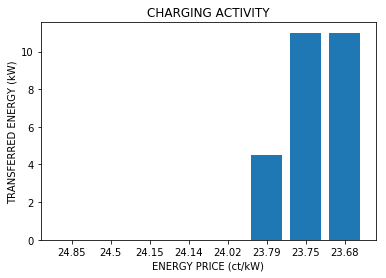

In [25]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

# Car specs: BMW I3
battCap = 37.9
maxCharRateCar = 11

#Scenario values
startTime = 8
endTime = 16
SoC_per_beg = 0.1
SoC_per_end = 0.8
maxCharRateStation = 11

charRate = min(maxCharRateCar,maxCharRateStation)

### Built Model
mDynamic = Model()

### Energy needed
SoC_beg = battCap * SoC_per_beg
SoC_end = battCap * SoC_per_end
sumTransferedEnergy = SoC_end - SoC_beg

'''
Dynamic Price data taken from https://www.awattar.de/ (09.07.2019)
Price consists of fixed price (19.61 ct/kWh) + energy stock market price
Basic montly fee: 13.33€

'''

fixedPrice = 19.61
varPrices = [3.76, 3.59, 3.55, 3.5, 3.56, 3.63,
          4.3, 5.23, 5.24, 4.89, 4.54, 4.53,
          4.41, 4.18, 4.14, 4.07, 4.13, 4.37,
          4.8, 5.59, 5.7, 5.47, 5.22, 4.36]
prices = [v + fixedPrice for v in varPrices]


'''
Retail price taken from https://www.vattenfall.de/stromtarife/strom-natur24 (Access: 14.07.2019)
Only sustainable power supply for better comparison
Price per kWh: 27.74 ct/kWh
Basic montly fee: 10.30 €
'''
retailPrice = 27.74

retailChargingCosts = sumTransferedEnergy * retailPrice

### Charging time & prices
chargingDuration = endTime - startTime
chargingInterval = np.arange(chargingDuration)
realChargingDuration = sumTransferedEnergy/charRate
chargingPrices = prices[startTime:endTime]


### Variables
chargingRate = list()
for t in chargingInterval:
    chargingRate.append(mDynamic.addVar(vtype = 'C', lb=0.0, ub=charRate))
    
### Constraints
mDynamic.addConstr((quicksum(chargingRate) == sumTransferedEnergy))

mDynamic.update()

### Objective Function
mDynamic.setObjective(quicksum(chargingPrices[t]*chargingRate[t] for t in chargingInterval), GRB.MINIMIZE)

def printSolution():
    if m.status == GRB.Status.OPTIMAL:
        print('\n----------------------------------------------------------------\n')
        print('\nTotal energy transferred: %g kW' % sumTransferedEnergy)
        print('\nMinimal Charging Cost: %g ct' % mDynamic.objVal)
        print('\nTotal used charging time: %g h' % realChargingDuration)
        print('\nEnergy transferred during each hour:')
        chargex = m.getAttr('x', chargingRate)
        for t in np.arange(8):
            print('\n%s: %g kW - %f ct/kW' % (t, chargex[t], chargingPrices[t]))
        print('\n----------------------------------------------------------------\n')
        print('\nCharging costs using retail prices: %s ct' % (retailChargingCosts))
    else:
        print('No solution')
        
mDynamic.optimize()
printSolution()

chargingActivity = m.getAttr('x', chargingRate)

### time_slots = ['0-1','1-2','2-3','3-4','4-5','5-6','6-7','7-8']
timeSlots = [str(chargingPrices[x]) for x in range(chargingDuration)]
plt.bar(timeSlots,chargingActivity)
plt.ylabel('TRANSFERRED ENERGY (kW)')
plt.xlabel('ENERGY PRICE (ct/kW)')
plt.title('CHARGING ACTIVITY')

plt.show()

charging costs without scheduling:  652.2495


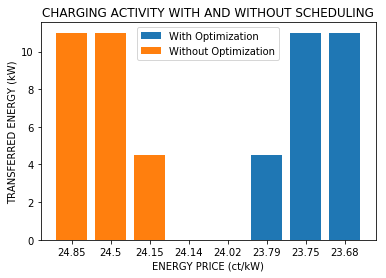

3.49 % can be saved when using optimized charging


In [27]:
### Optimized charging
### Blue

timeSlots = [str(chargingPrices[x]) for x in range(chargingDuration)]
plt.bar(timeSlots,chargingActivity, label = 'With Optimization')
plt.ylabel('TRANSFERRED ENERGY (kW)')
plt.xlabel('ENERGY PRICE (ct/kW)')
plt.title('CHARGING ACTIVITY')

### Baseline for evaluation: Standard charging
### Orange

chargingActivityBaseline = sorted(chargingActivity, reverse = True)

totalCostsBaseline = sum([sorted(chargingActivity, reverse = True)[t] * chargingPrices[t] for t in range(8)])

print('charging costs without scheduling: ', totalCostsBaseline)

timeSlots = [str(chargingPrices[x]) for x in range(chargingDuration)]
plt.bar(timeSlots,chargingActivityBaseline, label = 'Without Optimization')
plt.ylabel('TRANSFERRED ENERGY (kW)')
plt.xlabel('ENERGY PRICE (ct/kW)')
plt.title('CHARGING ACTIVITY WITH AND WITHOUT SCHEDULING')
plt.legend(loc = 'best')
plt.show()

savingsPercentage = round((1 - (mDynamic.ObjVal / totalCostsBaseline)) * 100,2)
print('%s %% can be saved when using optimized charging' % (savingsPercentage))

Text(0.5, 1.0, 'CHARGING PRICES')

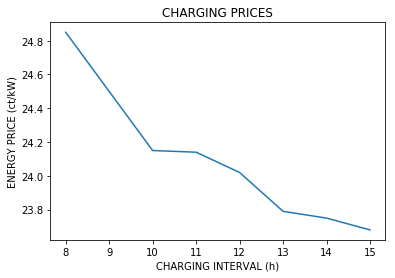

In [20]:
### Plot for charging prices during specified interval
plt.plot(np.arange(8,16),chargingPrices)
plt.ylabel('ENERGY PRICE (ct/kW)')
plt.xlabel('CHARGING INTERVAL (h)')
plt.title('CHARGING PRICES')

Text(0.5, 1.0, 'CHARGING PRICES')

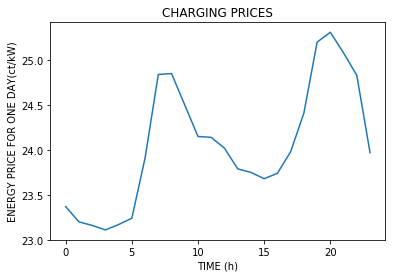

In [21]:
### Plot of charging prices for one day
plt.plot(np.arange(0,24),prices)
plt.ylabel('ENERGY PRICE FOR ONE DAY(ct/kW)')
plt.xlabel('TIME (h)')
plt.title('CHARGING PRICES')